In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import scipy
import time
import gget
from sklearn.decomposition import PCA
from kneed import KneeLocator
from importlib import reload

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.patheffects as pe

"""WARNING: disabling future warnings"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # and to omit tensorflow logging

""" Increase scanpy output"""
sc.settings.verbosity = 3

# local 
import utils as ut
reload(ut)

<module 'utils' from '/home/cstansbu/git_repositories/MC3R/notebooks/utils.py'>

In [2]:
fullpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/processed_data/all_subclustered.h5ad"
raw = sc.read(fullpath)

pdf = raw.copy()
pdf

AnnData object with n_obs × n_vars = 33647 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes', 'color', 'leiden', 'cluster_num', 'Cluster', 'cluster_cat', 'U1', 'U2', 'cell_type', 'neuron_clusters', 'neuron_cluster_num', 'neuron_cluster_name', 'neuron_cluster_cat', 'NU1', 'NU2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cluster', 'Cluster_colors', 'batch_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'neuron_clusters_colors', 'neuron_clusters_sizes', 'neuron_neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'neuron_neighbors_connectivities', 'neuron_neighbors_distances'

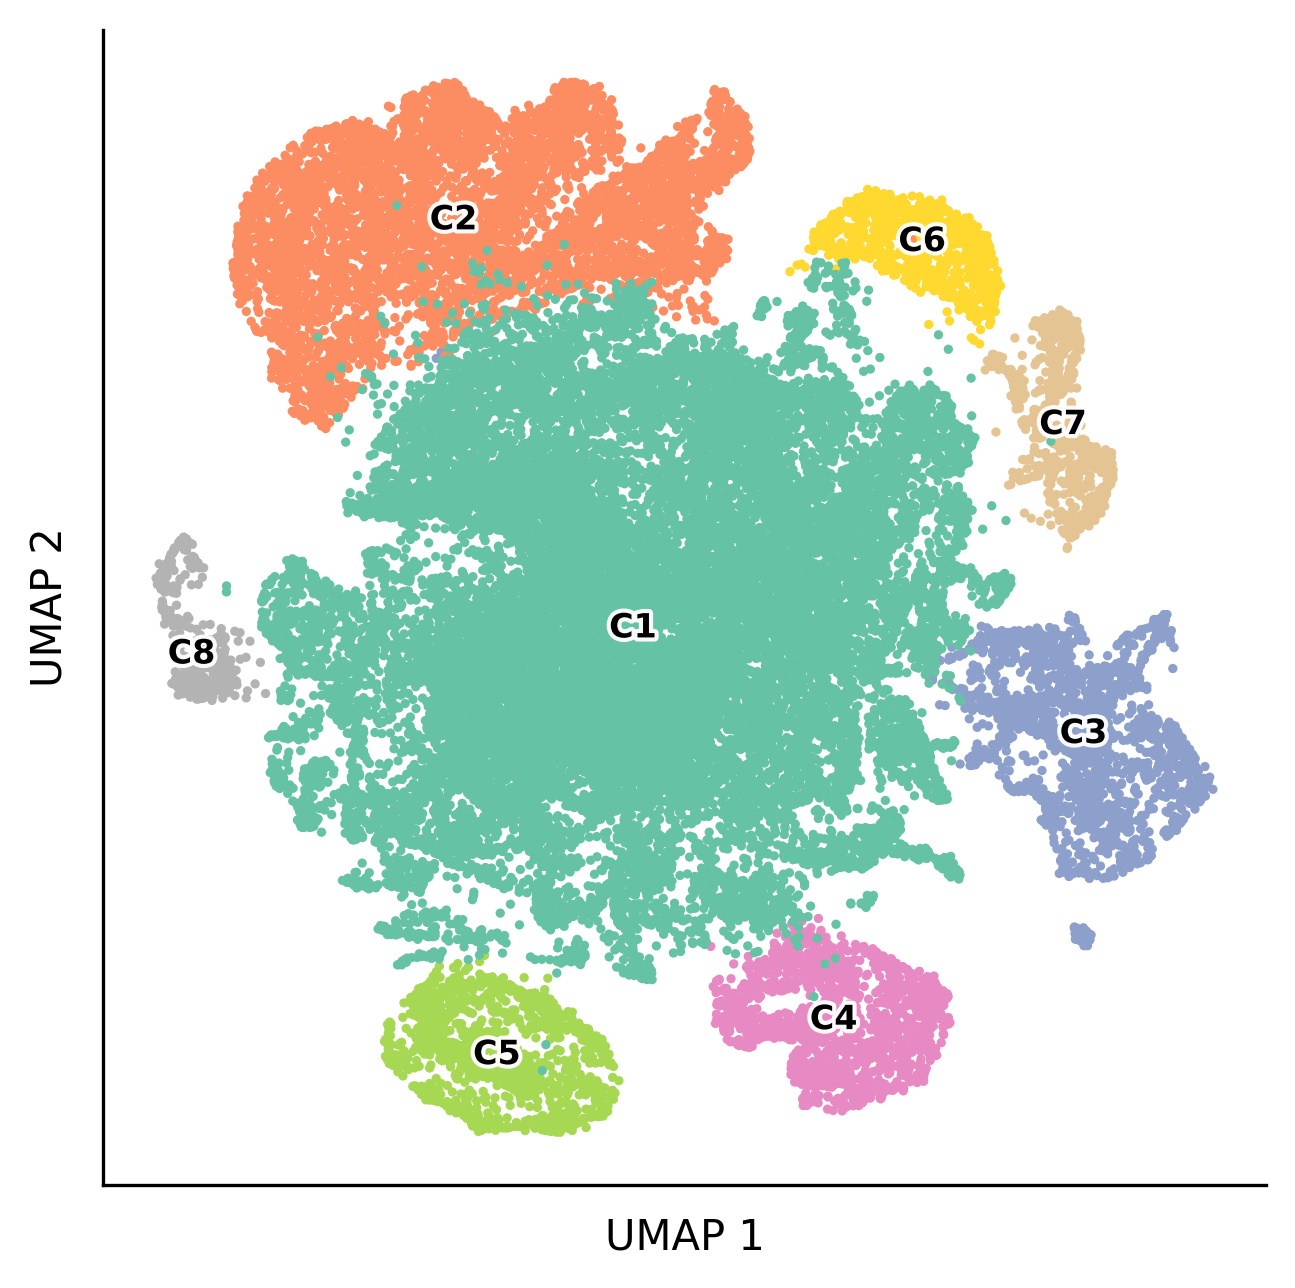

In [3]:
color_map = "Set2"

""" UMAP PLOT """
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

# sort the data frame
pdx = pdf.obs.copy()
pdx = pdx.sort_values(by='cell_type')
pdx = pdx.reset_index()

hue_order = sorted(pdx['neuron_cluster_name'].unique())
order = np.argsort(pdx['neuron_cluster_name'])[::-1]

sns.scatterplot(data=pdx.iloc[order],
                x='NU1',
                y='NU2',
                hue='neuron_cluster_name',
                hue_order=hue_order,
                palette=color_map,
                s=5,
                alpha=1.0,
                ec='none'
        )

sns.despine()
plt.xticks([])
plt.yticks([])

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# label on data
ax = plt.gca()

all_pos = (
        pdx.groupby('neuron_cluster_name')[['NU1', 'NU2']]
        .median()
        .sort_index()
    )

for label, x_pos, y_pos in all_pos.itertuples():
    ax.text(
        x_pos,
        y_pos,
        label,
        weight='bold',
        path_effects=[pe.withStroke(linewidth=2, foreground="w", alpha=0.95,)],
        verticalalignment="center",
        horizontalalignment="center",
        fontsize='8',
    )

plt.gca().legend().remove()


# outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/analysis_files/figures/neuron_cluster_umap.png"
# plt.savefig(outpath)
# print(f"saved: {outpath}")

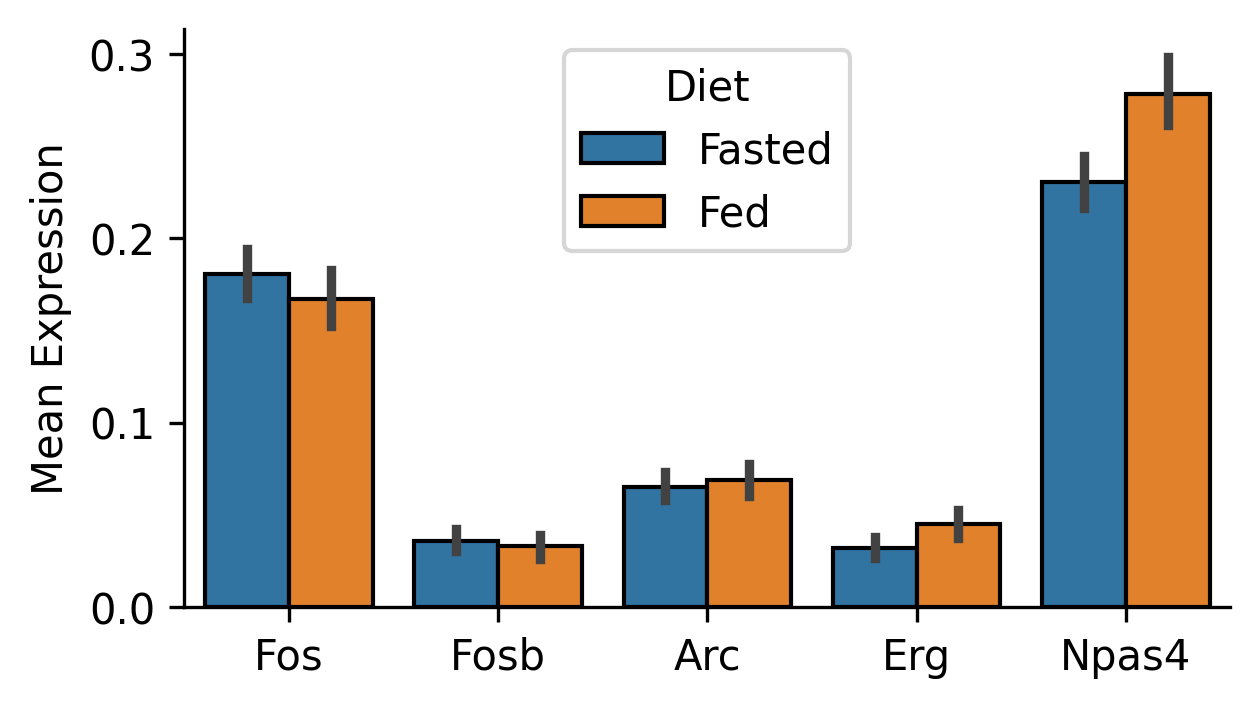

In [24]:
def plot_genes_by_fed(pdf, genes):
    pdx = pdf.obs.copy()
    pdx['Diet'] = pdx['Diet'].str.title()
    exp = pdf.to_df()
    exp  = exp[genes]
    pdx = pd.concat([pdx, exp], axis=1)

    pdx = pd.melt(pdx, 
                  id_vars=['Sex', 'Diet', 'neuron_cluster_name'],
                  value_vars=genes)
    
    sns.barplot(data=pdx, 
                x='variable',
                y='value',
                hue='Diet',
                ec='k',
               )

    plt.ylabel('Mean Expression')
    plt.xlabel('')
    sns.despine()
    

    
label_genes = [
    'Fos',
    'Fosb',
    'Arc',
    'Erg',
    'Npas4'
]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 2.5
plot_genes_by_fed(pdf, label_genes)

# diet DEG

In [25]:
key = 'Diet'

# get marker genes
sc.tl.rank_genes_groups(pdf, 
                        groupby=key,
                        method='wilcoxon',
                        key_added=key,
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(pdf, 
                                  group=None,
                                  key=key)

deg.head()

ranking genes
    finished: added to `.uns['Diet']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:43)


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,fasted,Srsf10,49.996567,1.381293,0.0,0.0
1,fasted,Npy,44.910831,3.441035,0.0,0.0
2,fasted,Gm26871,41.741756,1.101038,0.0,0.0
3,fasted,Peg3,39.191113,0.686879,0.0,0.0
4,fasted,Ptbp2,38.672394,1.000565,0.0,0.0


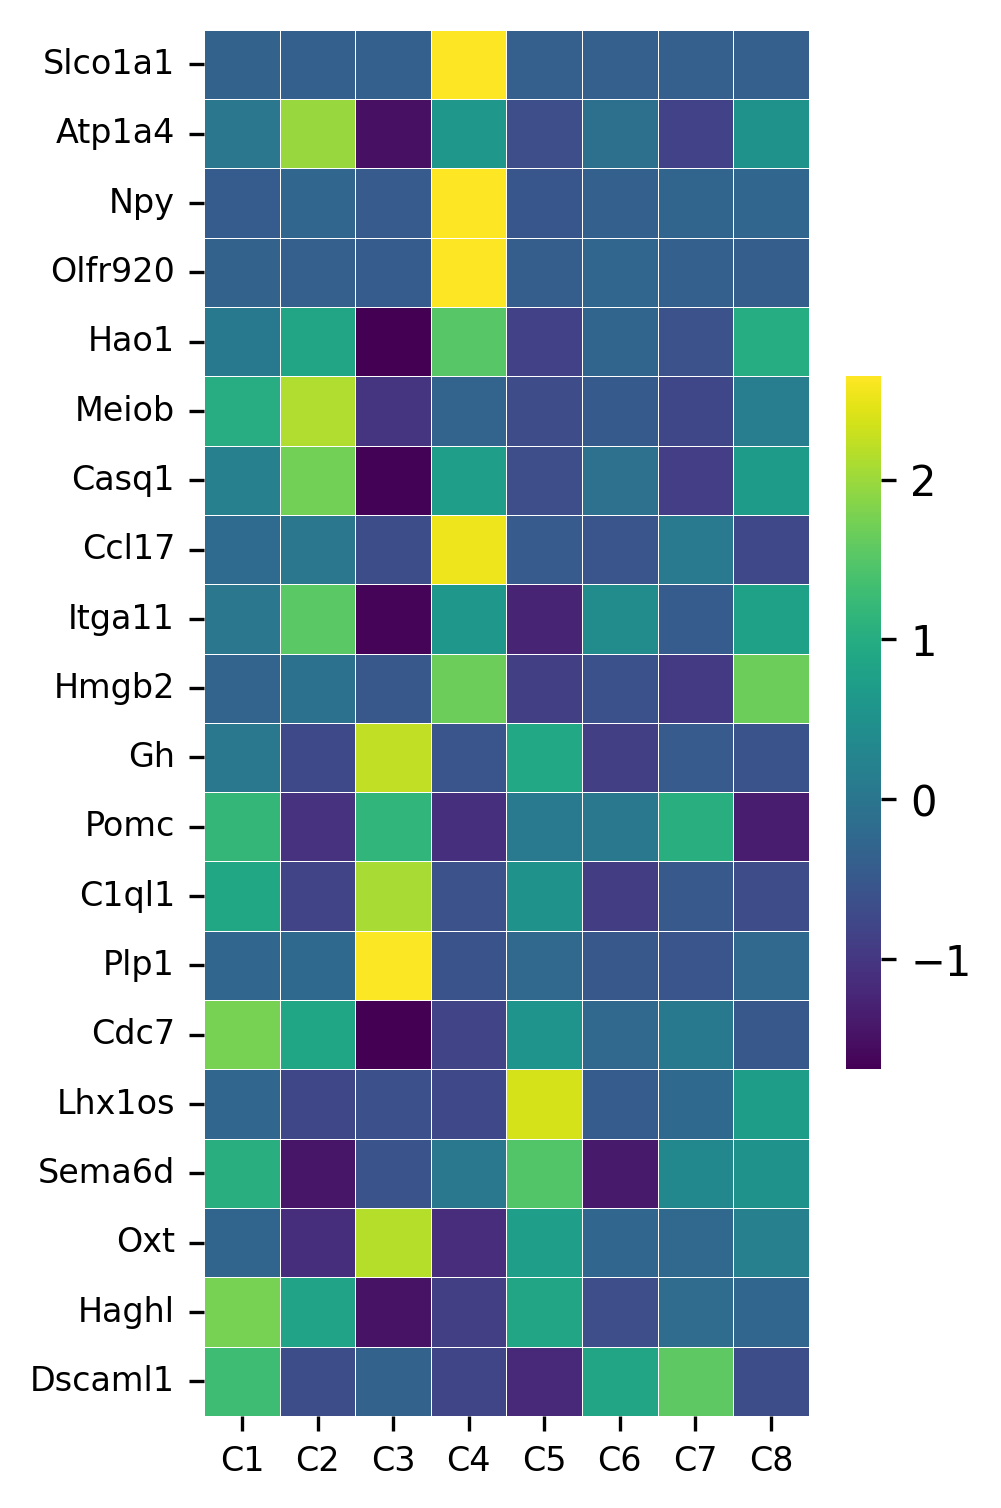

In [72]:
reload(ut)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3.25, 6

top_genes = ut.get_top_genes(deg, 
                             # label_genes, 
                             n_genes=10, 
                             lft=1.0, 
                             alpha=0.05,
                            )
top_genes


ut.plot_top_gene_heatmap(pdf, top_genes, fontsize=8,)

# TF analysis

In [41]:
# load mouse TFs
tf_path = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/scenic/tf_lists/allTFs_mm.txt"
tf = pd.read_csv(tf_path, header=None, names=['TF'])
print(f"{tf.shape=}")
tf.head()

tf.shape=(1860, 1)


,TF
0,Bcl6b
1,Zscan26
2,Mtf1
3,Klf9
4,Zic5


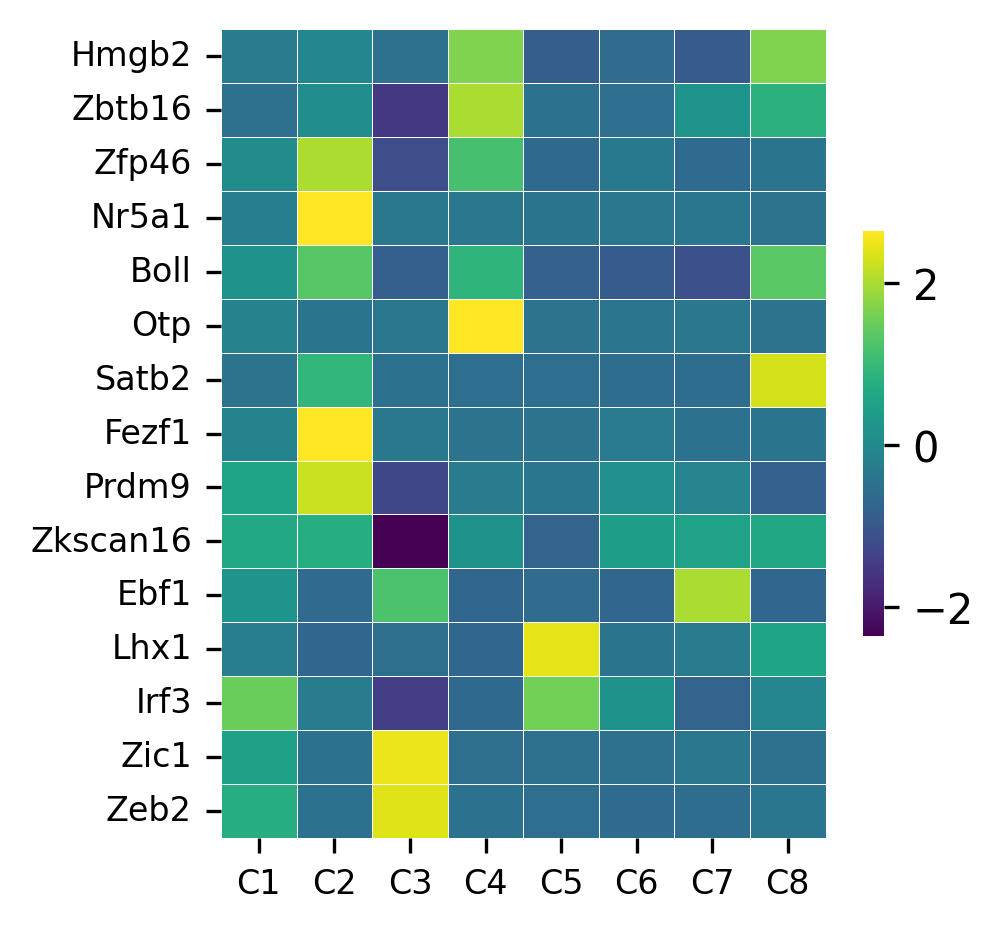

In [47]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3.25, 3.5

top_genes = ut.get_top_genes(deg, 
                             tf['TF'].to_list(),
                             n_genes=10, 
                             lft=1.0, 
                             alpha=0.05,
                            )


ut.plot_top_gene_heatmap(pdf, top_genes, fontsize=8,)

# Neuropeptides by feeding

In [49]:
# load neuropeptides
pep_path = "/nfs/turbo/umms-indikar/shared/projects/MC3R/neuropeptides/group-1902.csv"
ndf = pd.read_csv(pep_path, skiprows=1)

neuropeptides = ndf['Approved symbol'].unique()
neuropeptides = [x.lower().capitalize() for x in neuropeptides]
neuropeptides = [x for x in neuropeptides if x in pdf.var.index.to_list()]

print(f"{len(neuropeptides)=}")

len(neuropeptides)=53


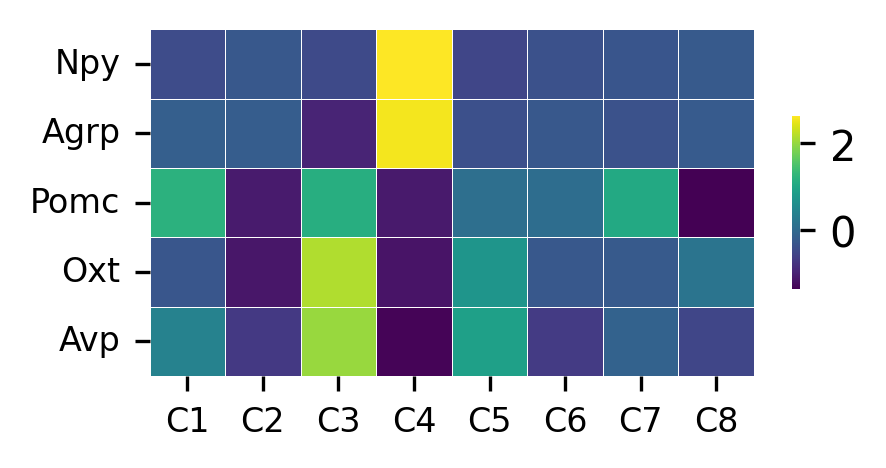

In [51]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3.25, 1.5

top_genes = ut.get_top_genes(deg, 
                             neuropeptides,
                             n_genes=10, 
                             lft=1.0, 
                             alpha=0.05,
                            )


ut.plot_top_gene_heatmap(pdf, top_genes, fontsize=8,)

# Fos analysis

In [52]:
# load mouse TFs
tf_path = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/processed_data/MOUSE_10kbp_up_10kbp_down_B.csv"
tf = pd.read_csv(tf_path)
print(f"{tf.shape=}")
tf = tf.rename(columns={'Unnamed: 0' : 'gene'})
tf = tf.set_index('gene')
tf.head()

tf.shape=(24130, 1606)


,ABL1,ACAA1,ADNP,ADNP2,AEBP2,AFF4,AHCTF1,AHDC1,AHR,AHRR,...,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5C,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3
gene,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,5.32,0.0,3.31,4.930,0.0655,12.50,8.31,4.375000,2.8724,0.0,...,0.0,0.0,0.0,4.66,2.29,0.0,0.000,0.000,0.0000,2.37
0610007P14Rik,9.93,0.0,3.46,1.380,0.0000,6.54,7.81,5.622500,2.9076,0.0,...,0.0,0.0,0.0,0.00,2.07,0.0,0.000,0.000,0.0000,5.35
0610009B22Rik,6.13,0.0,3.51,5.010,0.0000,18.30,9.89,5.761250,2.9654,0.0,...,0.0,0.0,0.0,3.40,2.35,0.0,0.000,0.000,0.0000,3.56
0610009L18Rik,2.74,0.0,5.09,0.484,0.0000,15.90,10.40,4.528125,2.4820,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,1.360,1.360,0.6800,4.39
0610009O20Rik,6.04,0.0,4.27,1.810,0.8250,19.00,10.80,8.325000,2.3242,0.0,...,0.0,0.0,0.0,7.98,7.74,0.0,0.751,0.751,0.3755,4.92


In [70]:
n_top = 1000

fos_targets = tf['FOS'].sort_values(ascending=False).head(n_top).index
fos_targets = [x for x in fos_targets if x in pdf.var_names]
print(len(fos_targets))

934


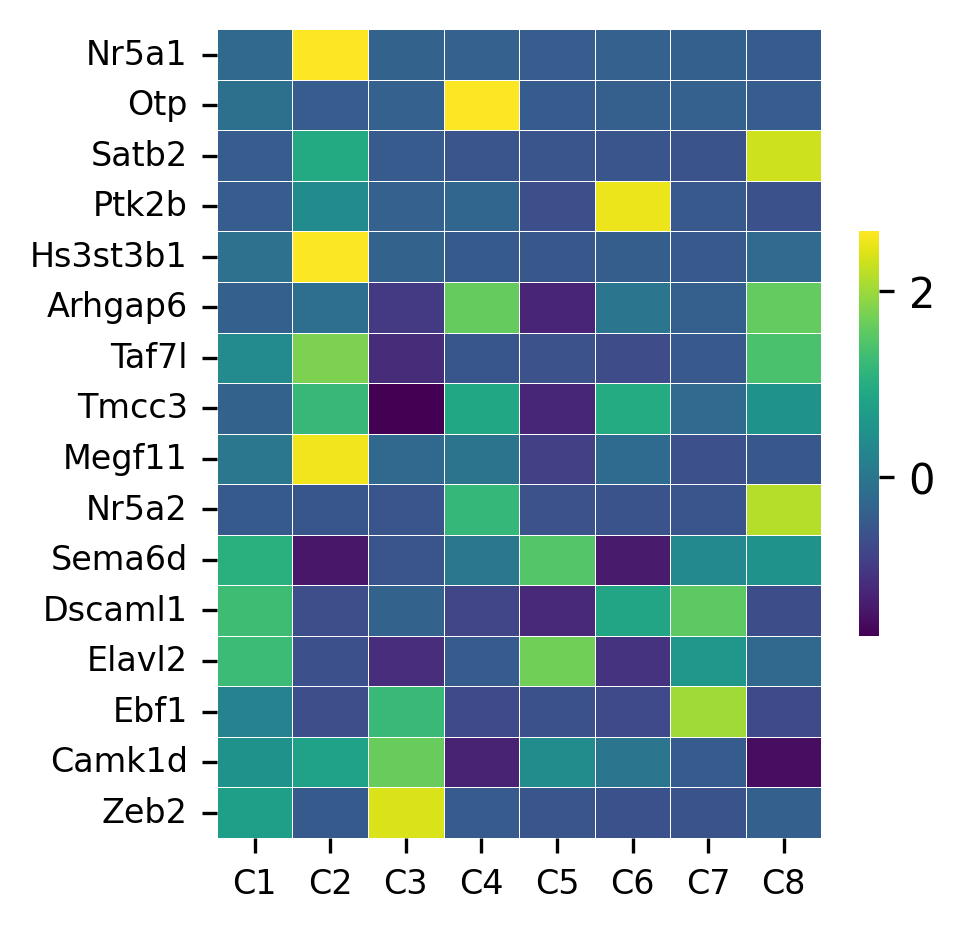

In [71]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3.25, 3.5

top_genes = ut.get_top_genes(deg, 
                             fos_targets,
                             n_genes=10, 
                             lft=1.0, 
                             alpha=0.05,
                            )


ut.plot_top_gene_heatmap(pdf, top_genes, fontsize=8,)

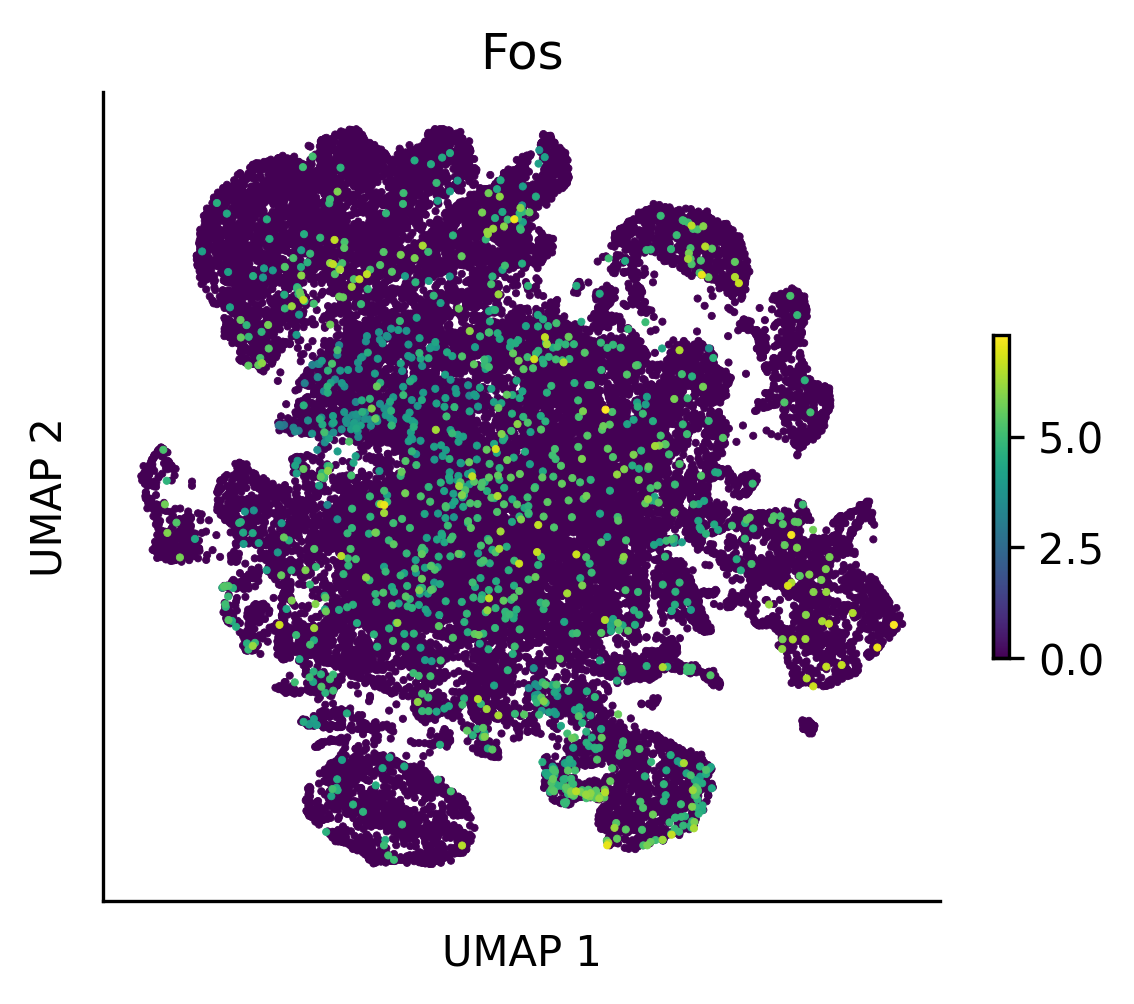

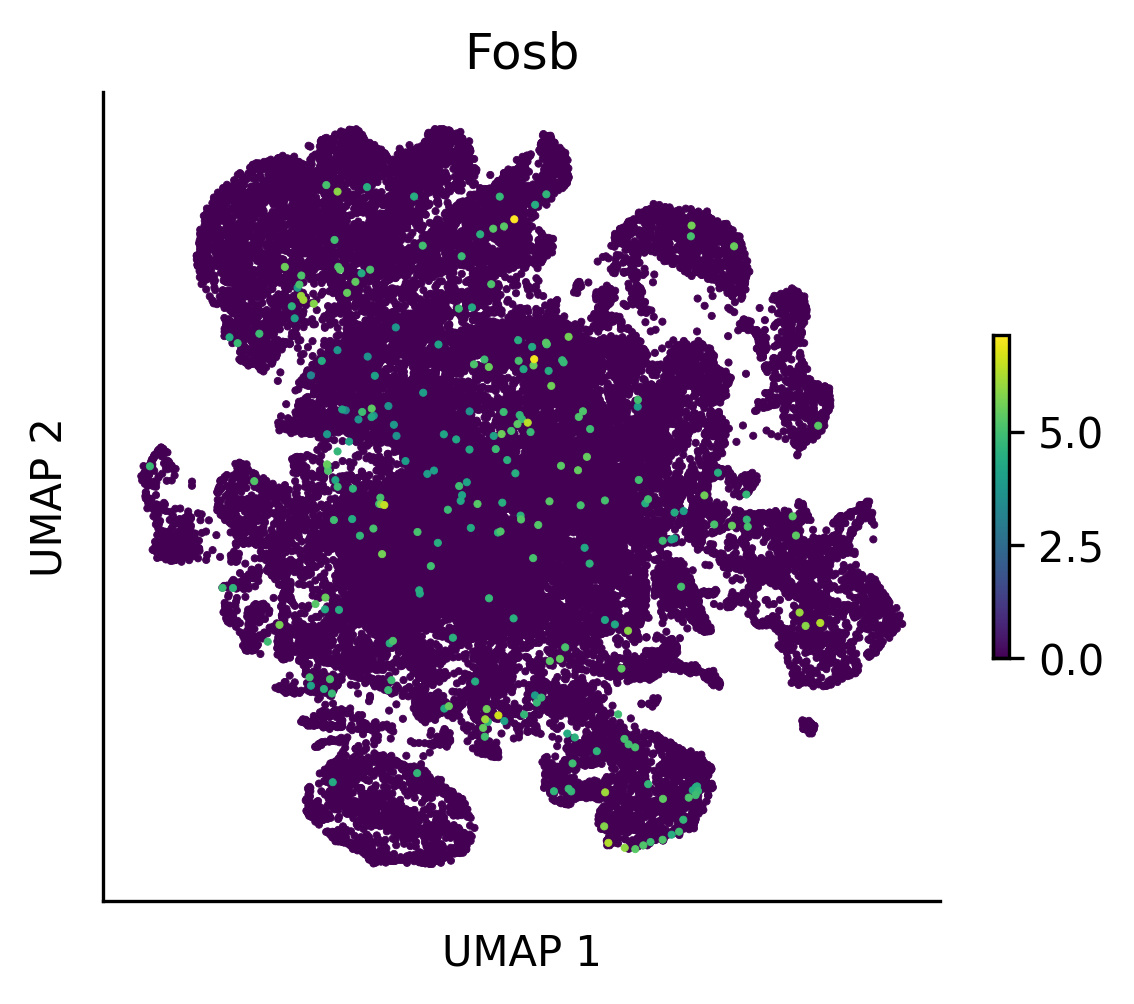

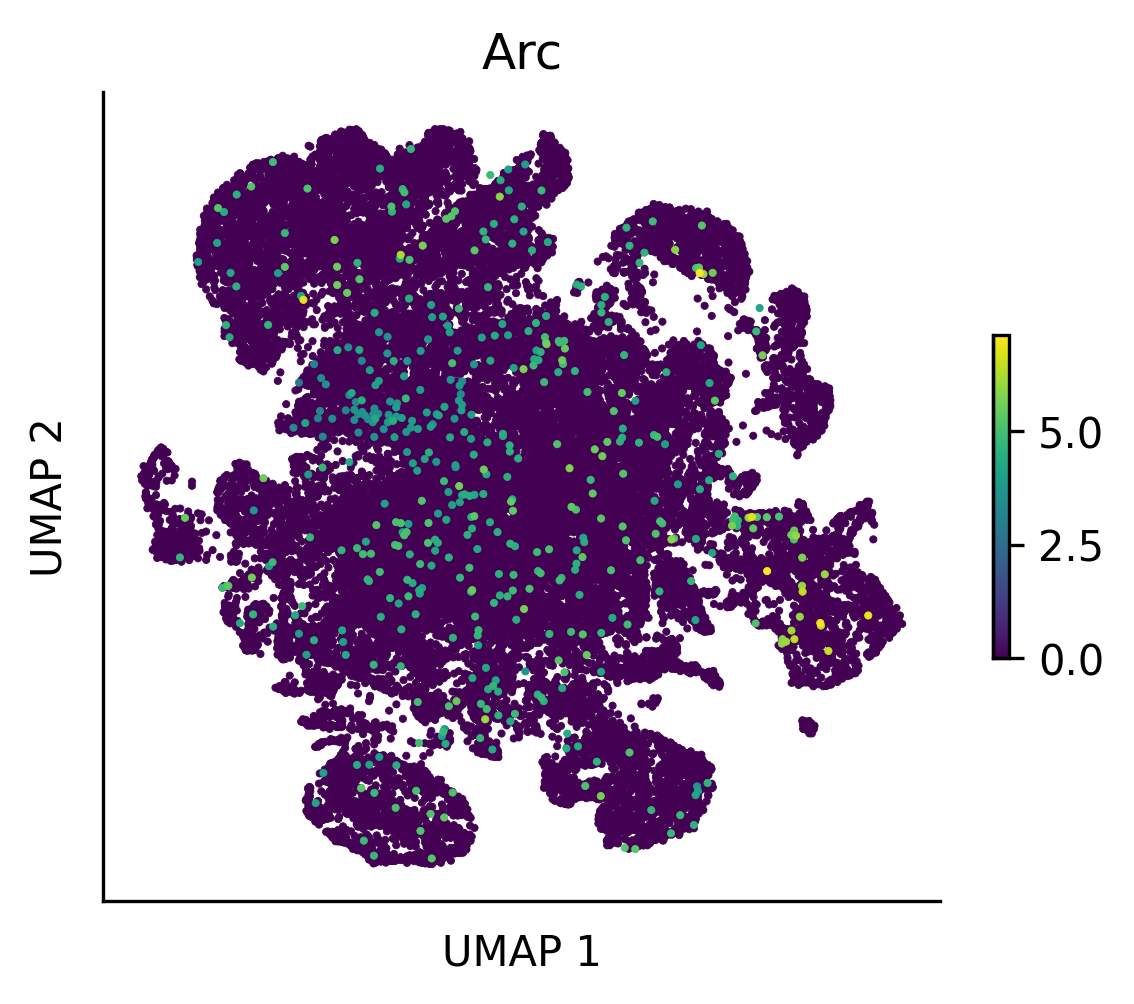

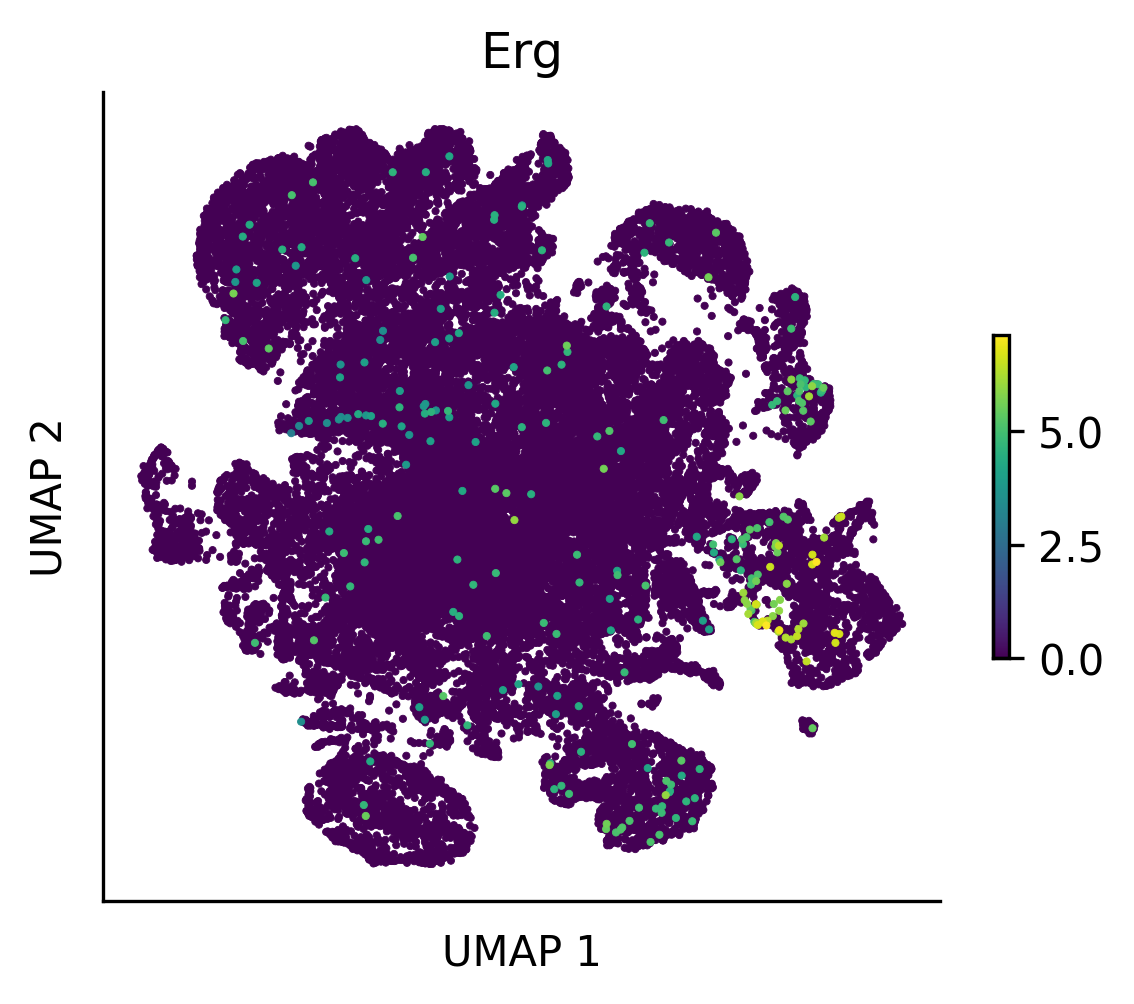

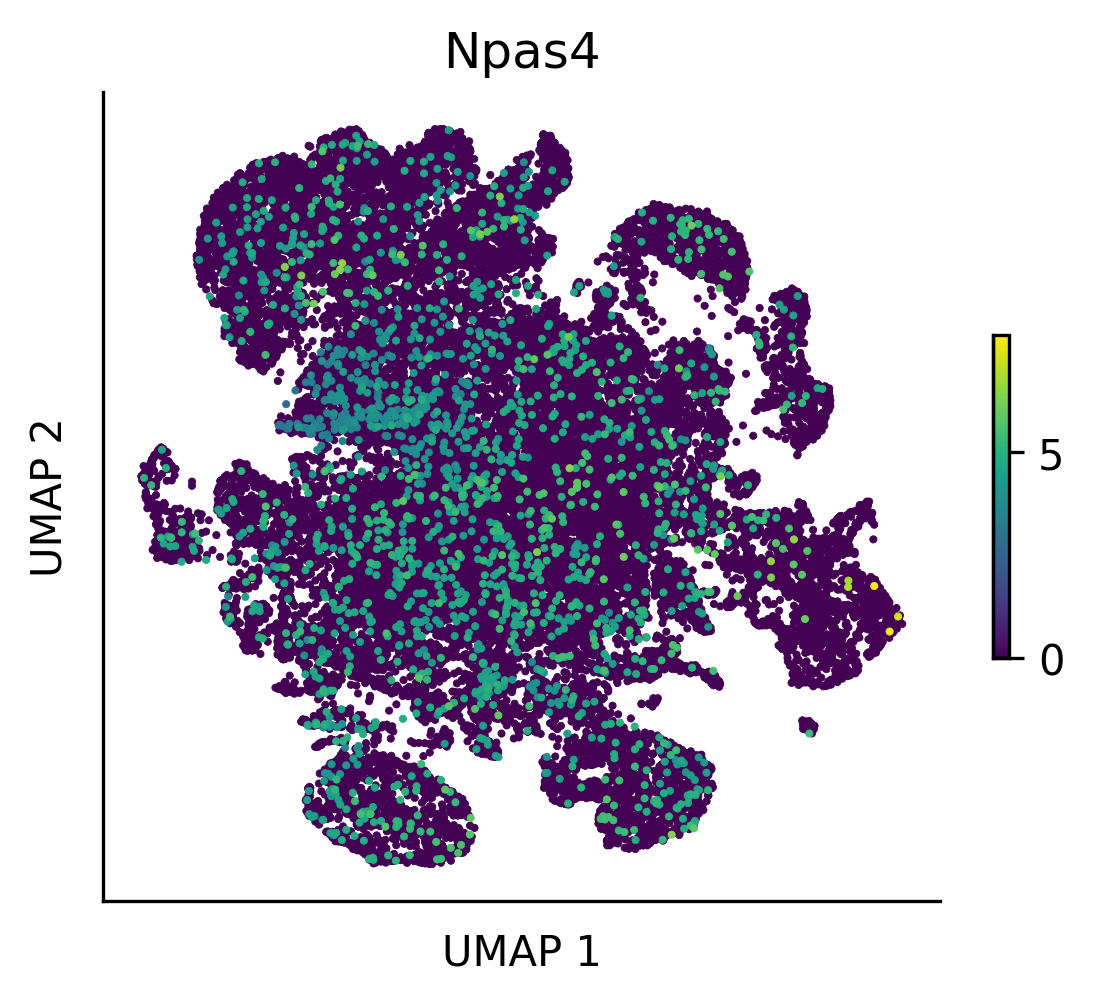

<Figure size 1350x1050 with 0 Axes>

In [13]:
label_genes = [
    'Fos',
    'Fosb',
    'Arc',
    'Erg',
    'Npas4'
]

images = []
s
for gene in label_genes:
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 4.5, 3.5
    p = ut.plot_umap_scatter(pdf,  x='NU1', y='NU2',
                             color=gene, s=3, alpha=1.0, 
                             linewidths=0.2)
    plt.show()
    plt.clf()

In [10]:
q = 'Npas'
[x for x in pdf.var_names if q in x]

['Npas2', 'Npas1', 'Npas3', 'Npas4']

In [ ]:


cfos, cfosB, arc, Egr1/Zif268, and Npas4